In [1]:
import keras
print(keras.__version__)

import tensorflow
print(tensorflow.__version__)

2.6.0
2.6.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import sys
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import skimage

from matplotlib import pyplot as plt
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import load_model
from tensorflow.python.framework import ops
from skimage import color

In [4]:
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [5]:
result_list_cam = []

In [6]:
def lch_colorFunction(image):

    lab_image = skimage.color.rgb2lab(image)
    converted_image = skimage.color.lab2lch(lab_image)

    min_1 = np.min(converted_image[:,:,0])
    max_1 = np.max(converted_image[:,:,0])
    converted_image[:,:,0] = np.round(((converted_image[:,:,0] - min_1) / (max_1 - min_1)) * 255)
   
    min_2 = np.min(converted_image[:,:,1])
    max_2 = np.max(converted_image[:,:,1])
    converted_image[:,:,1] = np.round(((converted_image[:,:,1] - min_2) / (max_2 - min_2)) * 255)
    
    min_3 = np.min(converted_image[:,:,2])
    max_3 = np.max(converted_image[:,:,2])
    converted_image[:,:,2] = np.round(((converted_image[:,:,2] - min_3) / (max_3 - min_3)) * 255)

    return converted_image 

In [7]:
def hsv_colorFunction(image):
  
    converted_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV) 
    
    min_1 = np.min(converted_image[:,:,0])
    max_1 = np.max(converted_image[:,:,0])
    converted_image[:,:,0] = np.round(((converted_image[:,:,0] - min_1) / (max_1 - min_1)) * 255)
   
    min_2 = np.min(converted_image[:,:,1])
    max_2 = np.max(converted_image[:,:,1])
    converted_image[:,:,1] = np.round(((converted_image[:,:,1] - min_2) / (max_2 - min_2)) * 255)
    
    min_3 = np.min(converted_image[:,:,2])
    max_3 = np.max(converted_image[:,:,2])
    converted_image[:,:,2] = np.round(((converted_image[:,:,2] - min_3) / (max_3 - min_3)) * 255)
    
    np.nan_to_num(converted_image, copy=False, nan=0.0, posinf=None, neginf=None)

    return converted_image 

In [8]:
def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    model = load_model('/content/gdrive/MyDrive/effnet_multidomain/transf_rgb_scale_lch_scale_hsv_bach256_lr001_epoc100.h5')
    return model

H, W = 224, 224 # Input shape, defined by the model (model.input_shape)                     

In [9]:
input_shape=(224,224,3)

def preprocess_input(imgx):
  return imgx.astype('float32').reshape((-1,)+input_shape) #/ 255

In [10]:
def load_image_lch(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = lch_colorFunction(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x  

In [11]:
def load_image_hsv(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = hsv_colorFunction(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x  

In [12]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x    

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th': #change for tf 2.0  image_dim_ordering () --> image_data_format()
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [13]:
tf.compat.v1.disable_eager_execution()

In [14]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""   
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]  

    # Normalize if necessary
    gradient_function = K.function([input_model.input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

In [15]:
def compute_saliency(model, img_path, layer_name, cls, visualize, save):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """

    rgb_img = load_image(img_path)
    lch_img = load_image_lch(img_path)
    hsv_img = load_image_hsv(img_path)
    preprocessed_input = [rgb_img, lch_img, hsv_img]
    predictions = model.predict(preprocessed_input)

    if cls == -1:
      cls = np.argmax(predictions)
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)

    #extracting image name alone 
    img_name_extension = os.path.basename(img_path)   
    img_name_alone = os.path.splitext(img_name_extension)
    temp_result_cam = [img_name_alone, cls]
    result_list_cam.append(temp_result_cam)
    basepath_cam = '/content/gdrive/MyDrive/gradcam/data/'

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite(basepath_cam+img_name_alone[0]+'_cam.jpg', np.uint8(jetcam))

    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
  
    return gradcam

In [16]:
model = build_model()

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
eff_rgb_0 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
eff_lch_0 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
eff_hsv_0 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
eff_rgb_1 (Rescaling)           (None, 224, 224, 3)  0           eff_rgb_0[0][0]                  
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


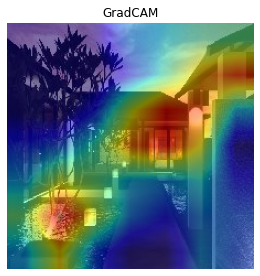

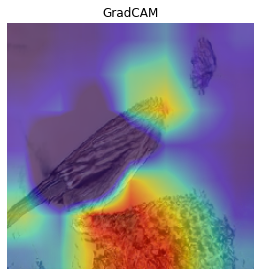

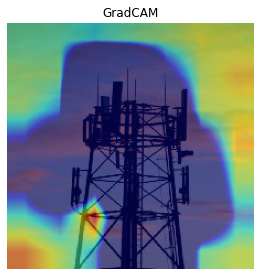

In [18]:
layer = 'eff_rgb_236'

directory = '/content/gdrive/MyDrive/gradcam/data/1'
img_num = 0

for filename in os.listdir(directory):
  img_num = img_num + 1
  if filename.endswith(".png") or filename.endswith(".jpg"):
    img = os.path.join(directory, filename)
    #print("image number = ",img_num)
    gradcam = compute_saliency(model, img, layer, cls=-1, visualize=True, save=False)

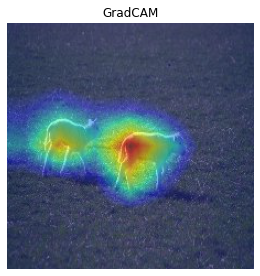

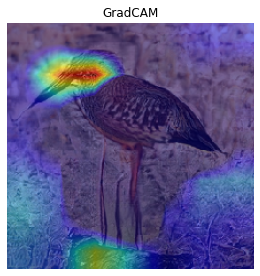

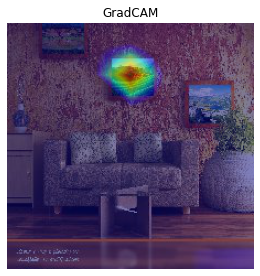

In [19]:
layer = 'eff_rgb_236'

directory = '/content/gdrive/MyDrive/gradcam/data/2'
img_num = 0

for filename in os.listdir(directory):
  img_num = img_num + 1
  if filename.endswith(".png") or filename.endswith(".jpg"):
    img = os.path.join(directory, filename)
    #print("image number = ",img_num)
    gradcam = compute_saliency(model, img, layer, cls=-1, visualize=True, save=False)